In [1]:
import os
import time
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import train_test_split

D:\Users\Alex\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import torch
import torch.nn as nn
#from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import models

import torchvision.transforms as transforms

In [3]:
from functions import(import_train_folder_dataset,
                      Data,
                      import_test_folder_dataset,
                      Data_test,
                      plot_loss_accuracy,
                      save_model,
                      save_metrics,
                      save_predictions_as_csv
                     )

# Variables

In [4]:
model_epochs = 100 # 100

lr = 0.006 # Learning rate.
                            
#torch.cuda.empty_cache()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


TRAIN_BATCH_SIZE = 8
TEST_BATCH_SIZE = 8

checkpoints_save = 100 # Save after 50 epochs

model_checkpoints = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/CheckPoints/"
PATH = "D:\\Personal\\Alex\\Uni\\MS IA\\2 Curso\\Fall 2022\Artificial Intelligence\\Projects\\Project 1\\Models Save\\GoogleNet_CAM-Plus-ImgClass\\"

# Path of the Data files
train_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/data/Croped/Train"
test_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/data/Croped/Test"

cuda


# Import Data

In [5]:

img_transform_val = transforms.Compose([transforms.ToPILImage(),
                                        transforms.Resize((400, 400)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])


invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

## Train-Val data

In [6]:
# Import the data
train_data, train_labels = import_train_folder_dataset(train_data_path)
print("Train Dim of Data: ", train_data.shape)
print("Train Dim of Lables: ", train_labels.shape)

Train Dim of Data:  (1149, 400, 400, 3)
Train Dim of Lables:  (1149,)


In [7]:
# Split into Train, Validation
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.1, random_state=1)
print("Dim of Data: ", X_train.shape)
print("Dim of Lables: ", y_train.shape)
print("Dim of X_test: ", X_val.shape)
print("Dim of y_test: ", y_val.shape)

Dim of Data:  (1034, 400, 400, 3)
Dim of Lables:  (1034,)
Dim of X_test:  (115, 400, 400, 3)
Dim of y_test:  (115,)


In [8]:
# Create the dataset object
train_Dataset = Data(X_train, y_train, img_transform_val) # img_transform_2 img_transform
val_Dataset = Data(X_val, y_val, img_transform_val)

print("Train len: ",len(train_Dataset))
print("Val len: ",len(val_Dataset))

Train len:  1034
Val len:  115


In [9]:
# Create the dataloaders
train_loader = DataLoader(
    train_Dataset, 
    batch_size=TRAIN_BATCH_SIZE,             
    shuffle=True)

valid_loader = DataLoader(
    val_Dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
    )

## Test Data

In [10]:
# Import the data
test_data, test_names = import_test_folder_dataset(test_data_path)
print("Test Dim of Data: ", test_data.shape)
print("Test Dim of Lables: ", test_names.shape)

Test Dim of Data:  (380, 400, 400, 3)
Test Dim of Lables:  (380,)


In [11]:
# Create the dataset object
test_Dataset = Data_test(test_data, test_names, img_transform_val) # img_transform_2 img_transform

print("Test len: ",len(test_Dataset))

Test len:  380


In [12]:
# Create the dataloaders
test_loader = DataLoader(
    test_Dataset, 
    batch_size=1,             
    shuffle=False)

# Create Model

In [13]:
#PyTorch - Building the Model
class ClassificationNet(nn.Module):
    def __init__(self, resnet50):
        super(ClassificationNet, self).__init__()
        
        # Get the feature extractor
        self.resnet50_fe = nn.Sequential(*list(resnet50.children())[:-1])

        
        # Flatten the FE output
        self.flatten = nn.Flatten()
        
        # Add a clissifier
        self.last_classifier =  nn.Linear(in_features=2048, out_features=4)
        #self.last_classifier =  nn.Linear(in_features=1024, out_features=4)
        
    def forward(self, x): 
        x = self.resnet50_fe(x)
        
        x = self.flatten(x)
        
        x = self.last_classifier(x)
        
        return x

modelpy = ClassificationNet(resnet50 = models.resnet50(pretrained=True)).to(device)

# Loss Function
criterion_2 = nn.CrossEntropyLoss()

# Optimizer    
trainable_parameters_2 = filter(lambda p: p.requires_grad, modelpy.parameters())
#optimizer_2 = torch.optim.Adam(params=trainable_parameters_2, lr=lr)
optimizer_2 = torch.optim.SGD(params=trainable_parameters_2, lr=lr, momentum=1e-5) 

# Check if checkpoint is available, if so, load it
model_epoch_m2_check = 0
previous_time = 0

modelpy

D:\Users\Alex\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
D:\Users\Alex\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ClassificationNet(
  (resnet50_fe): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0

In [14]:
# Check if checkpoint is available, if so, load it
model_epoch_m2_check = 0
previous_time = 0
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="model_ckpt_m2.pth"):
        print("Loading saved checkpoint")
        checkpoint = torch.load(model_checkpoints + "model_ckpt_m2.pth")
        modelpy.load_state_dict(checkpoint['model_state_dict'])
        modelpy.to(device)
        optimizer_2.load_state_dict(checkpoint['optimizer_state_dict'])
        model_epoch_m2_check = checkpoint['epoch']
        criterion_2 = checkpoint['loss']
        previous_time = checkpoint['time']
        print(f"Epoch of the checkpoint: {model_epoch_m2_check}")


In [15]:
# Model Parameters

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"Model Parameters: {count_parameters(modelpy)}")

Model Parameters: 23516228


# Train Model

In [16]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"]=lr

Epoch 1 of 100


100%|██████████| 15/15 [00:04<00:00,  3.09it/s]


train loss:  0.1328537589230897
Val loss:  0.12570632540661356
train accuracy:  0.5174081237911026
Val accuracy:  0.5304347826086957
Best model at the moment with Val_acc 53.04, saving...
Current time: 2.724 minutes. Time expected till completion: 269.675 minutes
Epoch 2 of 100


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


train loss:  0.11698707851727189
Val loss:  0.12099380078523056
train accuracy:  0.6141199226305609
Val accuracy:  0.5739130434782609
Best model at the moment with Val_acc 57.39, saving...
Current time: 4.610 minutes. Time expected till completion: 225.913 minutes
Epoch 3 of 100


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


train loss:  0.11096946560783127
Val loss:  0.11808501896650894
train accuracy:  0.6218568665377177
Val accuracy:  0.6
Best model at the moment with Val_acc 60.0, saving...
Current time: 6.496 minutes. Time expected till completion: 210.049 minutes
Epoch 4 of 100


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


train loss:  0.10839510626903585
Val loss:  0.1105128780655239
train accuracy:  0.6160541586073501
Val accuracy:  0.5565217391304348
Current time: 8.376 minutes. Time expected till completion: 201.023 minutes
Epoch 5 of 100


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


train loss:  0.10754608404705557
Val loss:  0.11146879144336866
train accuracy:  0.6295938104448743
Val accuracy:  0.6086956521739131
Best model at the moment with Val_acc 60.87, saving...
Current time: 10.258 minutes. Time expected till completion: 194.894 minutes
Epoch 6 of 100


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


train loss:  0.10535856542435099
Val loss:  0.11440901186155236
train accuracy:  0.6305609284332688
Val accuracy:  0.591304347826087
Current time: 12.161 minutes. Time expected till completion: 190.518 minutes
Epoch 7 of 100


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


train loss:  0.10433221975885461
Val loss:  0.11660298368205195
train accuracy:  0.6479690522243714
Val accuracy:  0.5826086956521739
Current time: 14.077 minutes. Time expected till completion: 187.029 minutes
Epoch 8 of 100


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


train loss:  0.10085020610626708
Val loss:  0.1099119668421538
train accuracy:  0.6624758220502901
Val accuracy:  0.5304347826086957
Current time: 16.003 minutes. Time expected till completion: 184.031 minutes
Epoch 9 of 100


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


train loss:  0.10001586043281296
Val loss:  0.11407421930976536
train accuracy:  0.6547388781431335
Val accuracy:  0.591304347826087
Current time: 17.930 minutes. Time expected till completion: 181.289 minutes
Epoch 10 of 100


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


train loss:  0.09732544442325311
Val loss:  0.11372879017954288
train accuracy:  0.6721470019342359
Val accuracy:  0.6086956521739131
Current time: 19.871 minutes. Time expected till completion: 178.842 minutes
Epoch 11 of 100


100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


train loss:  0.09858328406653967
Val loss:  0.10999219884043154
train accuracy:  0.6682785299806576
Val accuracy:  0.6
Current time: 21.804 minutes. Time expected till completion: 176.411 minutes
Epoch 12 of 100


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


train loss:  0.09514307952711153
Val loss:  0.11951043787209883
train accuracy:  0.6702127659574468
Val accuracy:  0.6260869565217392
Best model at the moment with Val_acc 62.61, saving...
Current time: 23.742 minutes. Time expected till completion: 174.111 minutes
Epoch 13 of 100


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


train loss:  0.09249822475462864
Val loss:  0.1049409560535265
train accuracy:  0.6924564796905223
Val accuracy:  0.6260869565217392
Current time: 25.669 minutes. Time expected till completion: 171.788 minutes
Epoch 14 of 100


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


train loss:  0.09240774464445833
Val loss:  0.11906902297683385
train accuracy:  0.6818181818181818
Val accuracy:  0.6
Current time: 27.595 minutes. Time expected till completion: 169.512 minutes
Epoch 15 of 100


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


train loss:  0.09160961392308573
Val loss:  0.1059275658234306
train accuracy:  0.6992263056092843
Val accuracy:  0.6260869565217392
Current time: 29.516 minutes. Time expected till completion: 167.259 minutes
Epoch 16 of 100


100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


train loss:  0.08856797820710122
Val loss:  0.11466472097065138
train accuracy:  0.7001934235976789
Val accuracy:  0.6173913043478261
Current time: 31.442 minutes. Time expected till completion: 165.070 minutes
Epoch 17 of 100


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


train loss:  0.08780073802521889
Val loss:  0.11341879186422929
train accuracy:  0.7263056092843327
Val accuracy:  0.6347826086956522
Best model at the moment with Val_acc 63.48, saving...
Current time: 33.373 minutes. Time expected till completion: 162.941 minutes
Epoch 18 of 100


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


train loss:  0.08474992673908949
Val loss:  0.11478859030682108
train accuracy:  0.7214700193423598
Val accuracy:  0.5565217391304348
Current time: 35.297 minutes. Time expected till completion: 160.799 minutes
Epoch 19 of 100


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


train loss:  0.0780919744152165
Val loss:  0.12111876114555027
train accuracy:  0.7514506769825918
Val accuracy:  0.6086956521739131
Current time: 37.223 minutes. Time expected till completion: 158.687 minutes
Epoch 20 of 100


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


train loss:  0.07729704551240231
Val loss:  0.11356659168782442
train accuracy:  0.7475822050290135
Val accuracy:  0.5652173913043478
Current time: 39.149 minutes. Time expected till completion: 156.596 minutes
Epoch 21 of 100


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


train loss:  0.07696183721896989
Val loss:  0.1206490853558416
train accuracy:  0.758220502901354
Val accuracy:  0.6
Current time: 41.075 minutes. Time expected till completion: 154.519 minutes
Epoch 22 of 100


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


train loss:  0.07438380485922963
Val loss:  0.12825037707453188
train accuracy:  0.776595744680851
Val accuracy:  0.6086956521739131
Current time: 43.001 minutes. Time expected till completion: 152.459 minutes
Epoch 23 of 100


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


train loss:  0.07020269125354128
Val loss:  0.13310413645661395
train accuracy:  0.7969052224371374
Val accuracy:  0.5739130434782609
Current time: 44.919 minutes. Time expected till completion: 150.381 minutes
Epoch 24 of 100


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


train loss:  0.06681976460165397
Val loss:  0.12900426983833313
train accuracy:  0.7804642166344294
Val accuracy:  0.6260869565217392
Current time: 46.842 minutes. Time expected till completion: 148.332 minutes
Epoch 25 of 100


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


train loss:  0.06772588790039491
Val loss:  0.12597641348838806
train accuracy:  0.7998065764023211
Val accuracy:  0.591304347826087
Current time: 48.764 minutes. Time expected till completion: 146.291 minutes
Epoch 26 of 100


100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


train loss:  0.05909423375902139
Val loss:  0.12687489519948544
train accuracy:  0.8201160541586073
Val accuracy:  0.591304347826087
Current time: 50.679 minutes. Time expected till completion: 144.241 minutes
Epoch 27 of 100


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


train loss:  0.059479724788746476
Val loss:  0.12385028808013253
train accuracy:  0.8259187620889749
Val accuracy:  0.6086956521739131
Current time: 52.587 minutes. Time expected till completion: 142.180 minutes
Epoch 28 of 100


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


train loss:  0.05797609143549976
Val loss:  0.14620209880497145
train accuracy:  0.8404255319148937
Val accuracy:  0.5304347826086957
Current time: 54.495 minutes. Time expected till completion: 140.129 minutes
Epoch 29 of 100


100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


train loss:  0.05554052123825139
Val loss:  0.12415637270264003
train accuracy:  0.8317214700193424
Val accuracy:  0.6
Current time: 56.391 minutes. Time expected till completion: 138.060 minutes
Epoch 30 of 100


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


train loss:  0.051506354086230756
Val loss:  0.1398612115694129
train accuracy:  0.8597678916827853
Val accuracy:  0.5652173913043478
Current time: 58.279 minutes. Time expected till completion: 135.984 minutes
Epoch 31 of 100


100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


train loss:  0.047336827322293065
Val loss:  0.14196781775225764
train accuracy:  0.8607350096711799
Val accuracy:  0.5391304347826087
Current time: 60.169 minutes. Time expected till completion: 133.924 minutes
Epoch 32 of 100


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


train loss:  0.046308266874438786
Val loss:  0.14449841406034386
train accuracy:  0.8829787234042553
Val accuracy:  0.6347826086956522
Current time: 62.056 minutes. Time expected till completion: 131.868 minutes
Epoch 33 of 100


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


train loss:  0.043107990780755216
Val loss:  0.15209753616996433
train accuracy:  0.879110251450677
Val accuracy:  0.5217391304347826
Current time: 63.936 minutes. Time expected till completion: 129.810 minutes
Epoch 34 of 100


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


train loss:  0.04311734558275866
Val loss:  0.1499867058318594
train accuracy:  0.8849129593810445
Val accuracy:  0.5652173913043478
Current time: 65.822 minutes. Time expected till completion: 127.773 minutes
Epoch 35 of 100


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


train loss:  0.04455534048104655
Val loss:  0.17292806195176166
train accuracy:  0.8762088974854932
Val accuracy:  0.591304347826087
Current time: 67.704 minutes. Time expected till completion: 125.736 minutes
Epoch 36 of 100


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


train loss:  0.03978741813335762
Val loss:  0.1463008849517159
train accuracy:  0.8810444874274661
Val accuracy:  0.6260869565217392
Current time: 69.591 minutes. Time expected till completion: 123.717 minutes
Epoch 37 of 100


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


train loss:  0.03359454575875626
Val loss:  0.14415768307188284
train accuracy:  0.90715667311412
Val accuracy:  0.6260869565217392
Current time: 71.479 minutes. Time expected till completion: 121.708 minutes
Epoch 38 of 100


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


train loss:  0.028164640288778384
Val loss:  0.1418001695819523
train accuracy:  0.9264990328820116
Val accuracy:  0.6434782608695652
Best model at the moment with Val_acc 64.35, saving...
Current time: 73.375 minutes. Time expected till completion: 119.717 minutes
Epoch 39 of 100


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


train loss:  0.03386815857661012
Val loss:  0.16912214756011962
train accuracy:  0.9100580270793037
Val accuracy:  0.5739130434782609
Current time: 75.269 minutes. Time expected till completion: 117.728 minutes
Epoch 40 of 100


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


train loss:  0.029434118870235042
Val loss:  0.15036876227544702
train accuracy:  0.937137330754352
Val accuracy:  0.6347826086956522
Current time: 77.163 minutes. Time expected till completion: 115.744 minutes
Epoch 41 of 100


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


train loss:  0.03047520695776612
Val loss:  0.16846676391103993
train accuracy:  0.9332688588007737
Val accuracy:  0.6260869565217392
Current time: 79.057 minutes. Time expected till completion: 113.765 minutes
Epoch 42 of 100


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


train loss:  0.027986794656117375
Val loss:  0.15460572216821752
train accuracy:  0.9284332688588007
Val accuracy:  0.5478260869565217
Current time: 80.953 minutes. Time expected till completion: 111.793 minutes
Epoch 43 of 100


100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


train loss:  0.03094799533789001
Val loss:  0.1479693011097286
train accuracy:  0.9158607350096711
Val accuracy:  0.6086956521739131
Current time: 82.844 minutes. Time expected till completion: 109.817 minutes
Epoch 44 of 100


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


train loss:  0.023838901555443062
Val loss:  0.17220376548559768
train accuracy:  0.9410058027079303
Val accuracy:  0.5739130434782609
Current time: 84.740 minutes. Time expected till completion: 107.851 minutes
Epoch 45 of 100


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


train loss:  0.025334194562860856
Val loss:  0.18638541050579238
train accuracy:  0.937137330754352
Val accuracy:  0.6086956521739131
Current time: 86.637 minutes. Time expected till completion: 105.889 minutes
Epoch 46 of 100


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


train loss:  0.025333740071139553
Val loss:  0.16601370417553446
train accuracy:  0.9390715667311412
Val accuracy:  0.6173913043478261
Current time: 88.539 minutes. Time expected till completion: 103.937 minutes
Epoch 47 of 100


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


train loss:  0.02059743202848061
Val loss:  0.16590651092321976
train accuracy:  0.960348162475822
Val accuracy:  0.6
Current time: 90.440 minutes. Time expected till completion: 101.985 minutes
Epoch 48 of 100


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


train loss:  0.021868381832097612
Val loss:  0.1601234644651413
train accuracy:  0.941972920696325
Val accuracy:  0.591304347826087
Current time: 92.342 minutes. Time expected till completion: 100.037 minutes
Epoch 49 of 100


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


train loss:  0.024210606049566135
Val loss:  0.15929917421029963
train accuracy:  0.9381044487427466
Val accuracy:  0.6173913043478261
Current time: 94.245 minutes. Time expected till completion: 98.092 minutes
Epoch 50 of 100


100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


train loss:  0.016646702101047024
Val loss:  0.18490794223287832
train accuracy:  0.965183752417795
Val accuracy:  0.5739130434782609
Current time: 96.149 minutes. Time expected till completion: 96.149 minutes
Epoch 51 of 100


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


train loss:  0.019409819006220918
Val loss:  0.19258999565373297
train accuracy:  0.9593810444874274
Val accuracy:  0.5739130434782609
Current time: 98.052 minutes. Time expected till completion: 94.207 minutes
Epoch 52 of 100


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


train loss:  0.01968982140578661
Val loss:  0.19935501347417417
train accuracy:  0.9506769825918762
Val accuracy:  0.6173913043478261
Current time: 99.959 minutes. Time expected till completion: 92.270 minutes
Epoch 53 of 100


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


train loss:  0.017991934361871208
Val loss:  0.1823625683784485
train accuracy:  0.9506769825918762
Val accuracy:  0.6086956521739131
Current time: 101.874 minutes. Time expected till completion: 90.341 minutes
Epoch 54 of 100


100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


train loss:  0.020519990409135356
Val loss:  0.18544057789056198
train accuracy:  0.9477756286266924
Val accuracy:  0.5652173913043478
Current time: 103.795 minutes. Time expected till completion: 88.418 minutes
Epoch 55 of 100


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


train loss:  0.02120021988441393
Val loss:  0.2198996961116791
train accuracy:  0.9468085106382979
Val accuracy:  0.5565217391304348
Current time: 105.717 minutes. Time expected till completion: 86.495 minutes
Epoch 56 of 100


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


train loss:  0.019273480950770052
Val loss:  0.18395656710085662
train accuracy:  0.9535783365570599
Val accuracy:  0.5826086956521739
Current time: 107.634 minutes. Time expected till completion: 84.570 minutes
Epoch 57 of 100


100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


train loss:  0.017275560303182273
Val loss:  0.17894541083470636
train accuracy:  0.960348162475822
Val accuracy:  0.6086956521739131
Current time: 109.552 minutes. Time expected till completion: 82.645 minutes
Epoch 58 of 100


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


train loss:  0.014681888672179134
Val loss:  0.21207937138236088
train accuracy:  0.971953578336557
Val accuracy:  0.5739130434782609
Current time: 111.473 minutes. Time expected till completion: 80.722 minutes
Epoch 59 of 100


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


train loss:  0.016059159966837794
Val loss:  0.21255019488541976
train accuracy:  0.9584139264990329
Val accuracy:  0.5826086956521739
Current time: 113.396 minutes. Time expected till completion: 78.801 minutes
Epoch 60 of 100


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


train loss:  0.018075686545296784
Val loss:  0.23370128714519997
train accuracy:  0.9661508704061895
Val accuracy:  0.5826086956521739
Current time: 115.316 minutes. Time expected till completion: 76.877 minutes
Epoch 61 of 100


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


train loss:  0.015279831185061448
Val loss:  0.1948539137840271
train accuracy:  0.9642166344294004
Val accuracy:  0.5739130434782609
Current time: 117.236 minutes. Time expected till completion: 74.954 minutes
Epoch 62 of 100


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


train loss:  0.013351153334191995
Val loss:  0.26930484668068266
train accuracy:  0.9642166344294004
Val accuracy:  0.591304347826087
Current time: 119.159 minutes. Time expected till completion: 73.033 minutes
Epoch 63 of 100


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


train loss:  0.014561676965644529
Val loss:  0.22273169759175052
train accuracy:  0.9671179883945842
Val accuracy:  0.5478260869565217
Current time: 121.085 minutes. Time expected till completion: 71.114 minutes
Epoch 64 of 100


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


train loss:  0.013887709058457319
Val loss:  0.2640780947130659
train accuracy:  0.971953578336557
Val accuracy:  0.4956521739130435
Current time: 123.005 minutes. Time expected till completion: 69.191 minutes
Epoch 65 of 100


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


train loss:  0.016328549870007043
Val loss:  0.20670533452344977
train accuracy:  0.9613152804642167
Val accuracy:  0.5826086956521739
Current time: 124.930 minutes. Time expected till completion: 67.270 minutes
Epoch 66 of 100


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


train loss:  0.015372307418541158
Val loss:  0.1972771890785383
train accuracy:  0.9661508704061895
Val accuracy:  0.6
Current time: 126.854 minutes. Time expected till completion: 65.349 minutes
Epoch 67 of 100


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


train loss:  0.01088447761438189
Val loss:  0.3081850580547167
train accuracy:  0.9748549323017408
Val accuracy:  0.4608695652173913
Current time: 128.780 minutes. Time expected till completion: 63.429 minutes
Epoch 68 of 100


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


train loss:  0.01661352237201939
Val loss:  0.18733453491459723
train accuracy:  0.9516441005802708
Val accuracy:  0.5652173913043478
Current time: 130.715 minutes. Time expected till completion: 61.513 minutes
Epoch 69 of 100


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


train loss:  0.01305127364486038
Val loss:  0.17666274024092632
train accuracy:  0.9661508704061895
Val accuracy:  0.6347826086956522
Current time: 132.647 minutes. Time expected till completion: 59.595 minutes
Epoch 70 of 100


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


train loss:  0.011263474076040579
Val loss:  0.188805518526098
train accuracy:  0.9700193423597679
Val accuracy:  0.6
Current time: 134.582 minutes. Time expected till completion: 57.678 minutes
Epoch 71 of 100


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


train loss:  0.007700464555838756
Val loss:  0.20253735016221586
train accuracy:  0.9893617021276596
Val accuracy:  0.5826086956521739
Current time: 136.514 minutes. Time expected till completion: 55.759 minutes
Epoch 72 of 100


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


train loss:  0.010388571797371113
Val loss:  0.17313973132682883
train accuracy:  0.9796905222437138
Val accuracy:  0.6347826086956522
Current time: 138.441 minutes. Time expected till completion: 53.838 minutes
Epoch 73 of 100


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


train loss:  0.011044246838356024
Val loss:  0.20003512841851814
train accuracy:  0.9700193423597679
Val accuracy:  0.6086956521739131
Current time: 140.365 minutes. Time expected till completion: 51.916 minutes
Epoch 74 of 100


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


train loss:  0.009207310732832355
Val loss:  0.20262153945539307
train accuracy:  0.9845261121856866
Val accuracy:  0.6173913043478261
Current time: 142.289 minutes. Time expected till completion: 49.994 minutes
Epoch 75 of 100


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


train loss:  0.011314011781703414
Val loss:  0.22624528408050537
train accuracy:  0.9690522243713733
Val accuracy:  0.5826086956521739
Current time: 144.208 minutes. Time expected till completion: 48.069 minutes
Epoch 76 of 100


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


train loss:  0.01223439133734617
Val loss:  0.2168784911217897
train accuracy:  0.9738878143133463
Val accuracy:  0.5043478260869565
Current time: 146.126 minutes. Time expected till completion: 46.145 minutes
Epoch 77 of 100


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


train loss:  0.01621175833529211
Val loss:  0.20771632026071135
train accuracy:  0.9564796905222437
Val accuracy:  0.5478260869565217
Current time: 148.057 minutes. Time expected till completion: 44.225 minutes
Epoch 78 of 100


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


train loss:  0.009704007250590094
Val loss:  0.2506474086123964
train accuracy:  0.9729206963249516
Val accuracy:  0.5565217391304348
Current time: 149.994 minutes. Time expected till completion: 42.306 minutes
Epoch 79 of 100


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


train loss:  0.009721531593164238
Val loss:  0.21420262637345688
train accuracy:  0.9806576402321083
Val accuracy:  0.5826086956521739
Current time: 151.924 minutes. Time expected till completion: 40.385 minutes
Epoch 80 of 100


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


train loss:  0.011307993432465488
Val loss:  0.20713520931160967
train accuracy:  0.9748549323017408
Val accuracy:  0.6
Current time: 153.845 minutes. Time expected till completion: 38.461 minutes
Epoch 81 of 100


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


train loss:  0.01675430292239308
Val loss:  0.25058448262836625
train accuracy:  0.965183752417795
Val accuracy:  0.5478260869565217
Current time: 155.763 minutes. Time expected till completion: 36.537 minutes
Epoch 82 of 100


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


train loss:  0.008842404097961748
Val loss:  0.19854734514070593
train accuracy:  0.9806576402321083
Val accuracy:  0.5826086956521739
Current time: 157.681 minutes. Time expected till completion: 34.613 minutes
Epoch 83 of 100


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


train loss:  0.009349616069136804
Val loss:  0.21945048829783564
train accuracy:  0.9796905222437138
Val accuracy:  0.5826086956521739
Current time: 159.600 minutes. Time expected till completion: 32.689 minutes
Epoch 84 of 100


100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


train loss:  0.010342545298691948
Val loss:  0.22557618618011474
train accuracy:  0.9738878143133463
Val accuracy:  0.5739130434782609
Current time: 161.519 minutes. Time expected till completion: 30.766 minutes
Epoch 85 of 100


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


train loss:  0.00881205810774595
Val loss:  0.21168960786384086
train accuracy:  0.9816247582205029
Val accuracy:  0.5739130434782609
Current time: 163.453 minutes. Time expected till completion: 28.845 minutes
Epoch 86 of 100


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


train loss:  0.009612795448617926
Val loss:  0.23349566291207852
train accuracy:  0.9758220502901354
Val accuracy:  0.6
Current time: 165.371 minutes. Time expected till completion: 26.921 minutes
Epoch 87 of 100


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


train loss:  0.007124802807428851
Val loss:  0.22828376655993254
train accuracy:  0.9854932301740812
Val accuracy:  0.5217391304347826
Current time: 167.293 minutes. Time expected till completion: 24.998 minutes
Epoch 88 of 100


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


train loss:  0.00925898173911996
Val loss:  0.23478654415711112
train accuracy:  0.9806576402321083
Val accuracy:  0.5739130434782609
Current time: 169.210 minutes. Time expected till completion: 23.074 minutes
Epoch 89 of 100


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


train loss:  0.006209392117122927
Val loss:  0.22010492585275485
train accuracy:  0.9845261121856866
Val accuracy:  0.591304347826087
Current time: 171.146 minutes. Time expected till completion: 21.153 minutes
Epoch 90 of 100


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


train loss:  0.009166250021576996
Val loss:  0.20578012803326481
train accuracy:  0.9758220502901354
Val accuracy:  0.5826086956521739
Current time: 173.064 minutes. Time expected till completion: 19.229 minutes
Epoch 91 of 100


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


train loss:  0.007559376119476576
Val loss:  0.21794402498913848
train accuracy:  0.9864603481624759
Val accuracy:  0.6086956521739131
Current time: 174.981 minutes. Time expected till completion: 17.306 minutes
Epoch 92 of 100


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


train loss:  0.008573595864229478
Val loss:  0.20359140971432563
train accuracy:  0.9806576402321083
Val accuracy:  0.5739130434782609
Current time: 176.894 minutes. Time expected till completion: 15.382 minutes
Epoch 93 of 100


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


train loss:  0.009232274213244209
Val loss:  0.1962525372919829
train accuracy:  0.9854932301740812
Val accuracy:  0.5739130434782609
Current time: 178.808 minutes. Time expected till completion: 13.459 minutes
Epoch 94 of 100


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


train loss:  0.00971145216618553
Val loss:  0.22949540744657101
train accuracy:  0.9758220502901354
Val accuracy:  0.591304347826087
Current time: 180.722 minutes. Time expected till completion: 11.535 minutes
Epoch 95 of 100


100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


train loss:  0.009309600111537539
Val loss:  0.1899081814872182
train accuracy:  0.9729206963249516
Val accuracy:  0.591304347826087
Current time: 182.635 minutes. Time expected till completion: 9.612 minutes
Epoch 96 of 100


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


train loss:  0.012622814354841638
Val loss:  0.22796542126199473
train accuracy:  0.9642166344294004
Val accuracy:  0.6
Current time: 184.551 minutes. Time expected till completion: 7.690 minutes
Epoch 97 of 100


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


train loss:  0.009445475875215364
Val loss:  0.2394696769507035
train accuracy:  0.9787234042553191
Val accuracy:  0.5304347826086957
Current time: 186.464 minutes. Time expected till completion: 5.767 minutes
Epoch 98 of 100


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


train loss:  0.006961046201847962
Val loss:  0.23616419641867928
train accuracy:  0.9796905222437138
Val accuracy:  0.5826086956521739
Current time: 188.376 minutes. Time expected till completion: 3.844 minutes
Epoch 99 of 100


100%|██████████| 15/15 [00:04<00:00,  3.45it/s]


train loss:  0.01324305883960031
Val loss:  0.20402890832527823
train accuracy:  0.9709864603481625
Val accuracy:  0.6260869565217392
Current time: 190.310 minutes. Time expected till completion: 1.922 minutes
Epoch 100 of 100


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


train loss:  0.005155857159856101
Val loss:  0.21850038520667864
train accuracy:  0.9922630560928434
Val accuracy:  0.5304347826086957
Saving model 2 checkpoint


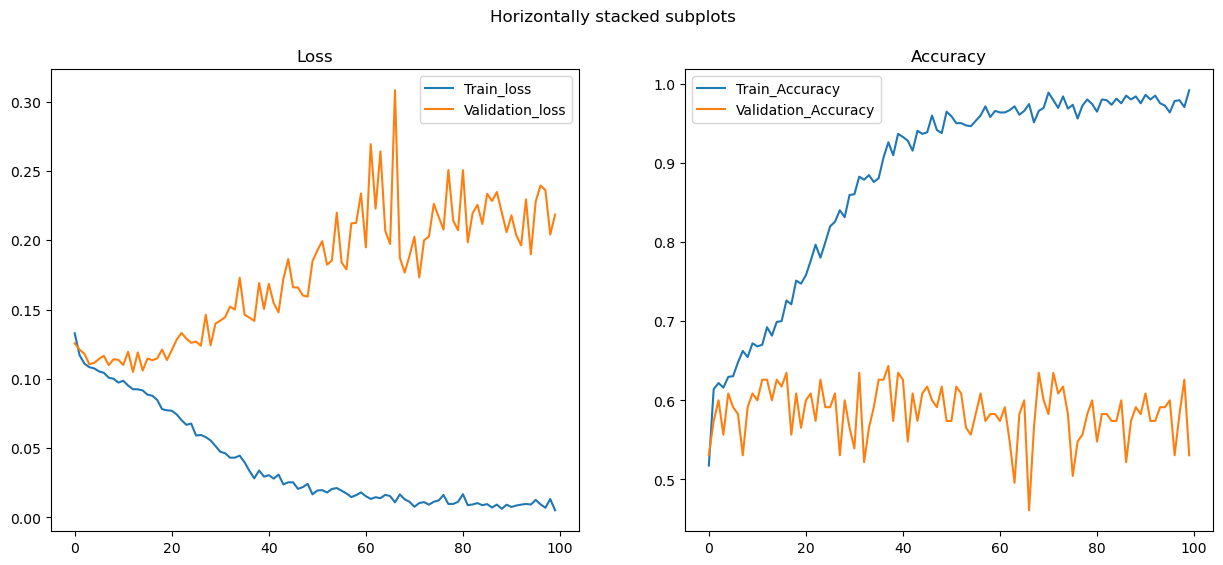

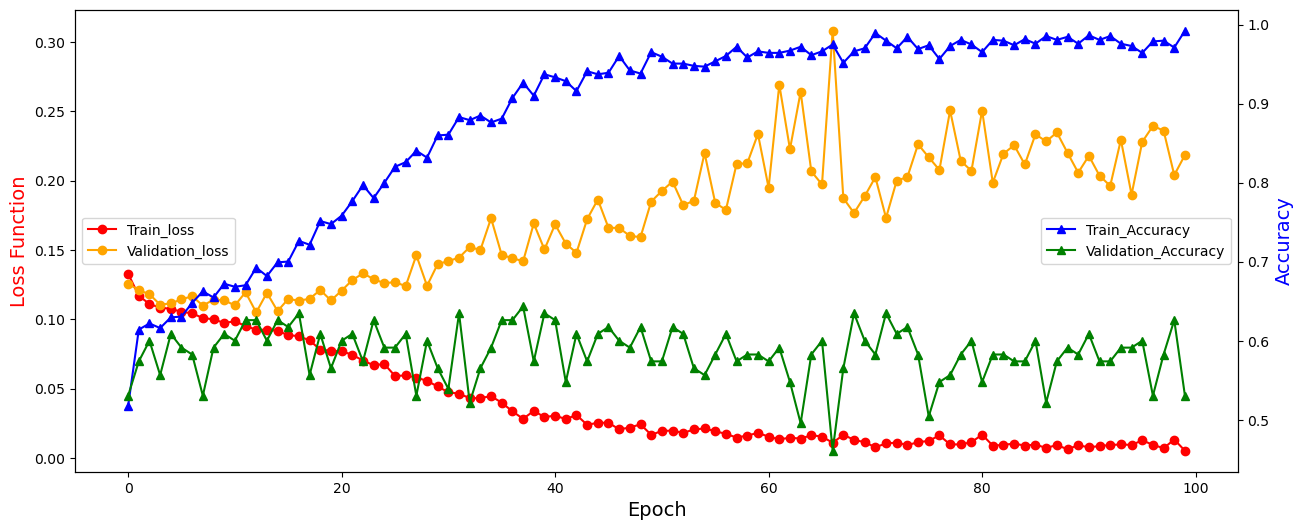

Current time: 192.670 minutes. Time expected till completion: 0.000 minutes
Finished training in: 192.680 minutes


In [17]:

best_model_val_acc = -1

train_loss, val_loss = [], []
train_accuracy, val_accuracy = [], []

# Load checkpoints
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="metrics_losss_accuracy_m2.csv"):
        print("Loading Metrics")
        dd = pd.read_csv(model_checkpoints + "metrics_losss_accuracy_m2.csv")
        train_loss = dd["train_loss"].tolist()
        val_loss = dd["val_loss"].tolist()
        train_accuracy = dd["train_accuracy"].tolist()
        val_accuracy = dd["val_accuracy"].tolist()

# count time
start = time.time()
for epoch in range(model_epoch_m2_check, model_epochs):
    # Print current epoch
    print(f"Epoch {epoch + 1} of {model_epochs}")
    
    if(epoch%10 == 0):
        update_optimizer(optimizer_2, 0.001)
        
    ############################################################################
    ################################ Train model ############################### 
    ############################################################################
    modelpy.train()
    running_loss=0
    total=0
    correct=0
    # loop for every training batch (one epoch)
    for bi, data in tqdm(enumerate(train_loader), total=len(train_loader)): # use tqdm package to track running time
        
        # Get the tensors
        images = data[0].to(device)# use the gpu
        labels = data[1].to(device)# use the gpu
        
        # Optimize second model
        
        #create the output from the CNN base on the give batch images
        out_m2 = modelpy(images)
        # count the loss function 
        loss_2 = criterion_2(out_m2, labels)    
        
        # BackPropagate on model 2
        ######################
        optimizer_2.zero_grad()
        ######################
        # count the backpropagation
        loss_2.backward()
        # learning
        optimizer_2.step()
        
        
        
        # add new value to the main loss
        running_loss += loss_2.item()
        
        # calculate accuracy
        predictions = torch.argmax(out_m2, dim=1)
        total += labels.size(0)
        correct +=(predictions == labels).sum().item()
        
        
    train_epoch_loss = running_loss/len(train_loader.dataset)
    
    train_epoch_accuracy = correct/total
    
    ############################################################################
    ################################ Eval model ################################ 
    ############################################################################
    modelpy.eval()
    running_loss = 0.0
    correct=0
    total=0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            # Get the tensors
            images = data[0].to(device)# use the gpu
            label = data[1].to(device)# use the gpu
            
            #create the output from the CNN base on the give batch images
            outputs = modelpy(images)
            # count the loss function
            loss = criterion_2(outputs, label)
            
            # Add loss of each item (total items in a batch = batch size) .
            running_loss += loss.item()
            
            # calculate accuracy
            predictions = torch.argmax(outputs, dim=1)
            total += label.size(0)
            correct +=(predictions == label).sum().item()
            
    val_epoch_loss = running_loss/len(valid_loader.dataset) 
    val_epoch_accuracy = correct/total
    
    
    print("train loss: ", train_epoch_loss)
    print("Val loss: ", val_epoch_loss)
    print("train accuracy: ", train_epoch_accuracy)
    print("Val accuracy: ", val_epoch_accuracy)

    
    # save results
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_accuracy.append(val_epoch_accuracy)
    
    # Save best model
    if(best_model_val_acc < val_epoch_accuracy):
        print(f"Best model at the moment with Val_acc {round(val_epoch_accuracy*100,2)}, saving...")
        # Save Model
        bestmodel_name = "model_2_bestModel.pt"
        torch.save(modelpy, PATH+bestmodel_name)
        best_model_val_acc = val_epoch_accuracy
    
    # Save model with all information every 100 epochs. Can be used 
    # resuming training. optim
    if (epoch+1) % checkpoints_save == 0: # checkpoints_save
        
        end = time.time()
        time_elapsed = (end-start)+previous_time
        
        # Save Model
        print("Saving model 2 checkpoint")
        save_model(epoch, time_elapsed, modelpy, optimizer_2, criterion_2, path = model_checkpoints + "model_ckpt_m2.pth")
        # save the metrics
        save_metrics(train_loss, val_loss, train_accuracy, val_accuracy, path = model_checkpoints + "metrics_losss_accuracy_m2.csv")
        
        # save model at epoch
        save_model(epoch, time_elapsed, modelpy, optimizer_2, criterion_2, path = model_checkpoints + "model_ckpt_m2_"+str(epoch+1)+".pth")
        
        
        # Check the evolution at this point
        plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)
        
        
    ep_time = time.time()
    print(f"Current time: {(((ep_time-start)+previous_time)/60):.3f} minutes. Time expected till completion: {(((((ep_time-start)+previous_time)/(epoch + 1)) * (model_epochs-(epoch + 1)))/60):.3f} minutes")
    
end = time.time()
print(f"Finished training in: {(((end-start)+previous_time)/60):.3f} minutes") 

In [18]:
best_model_val_acc

0.6434782608695652

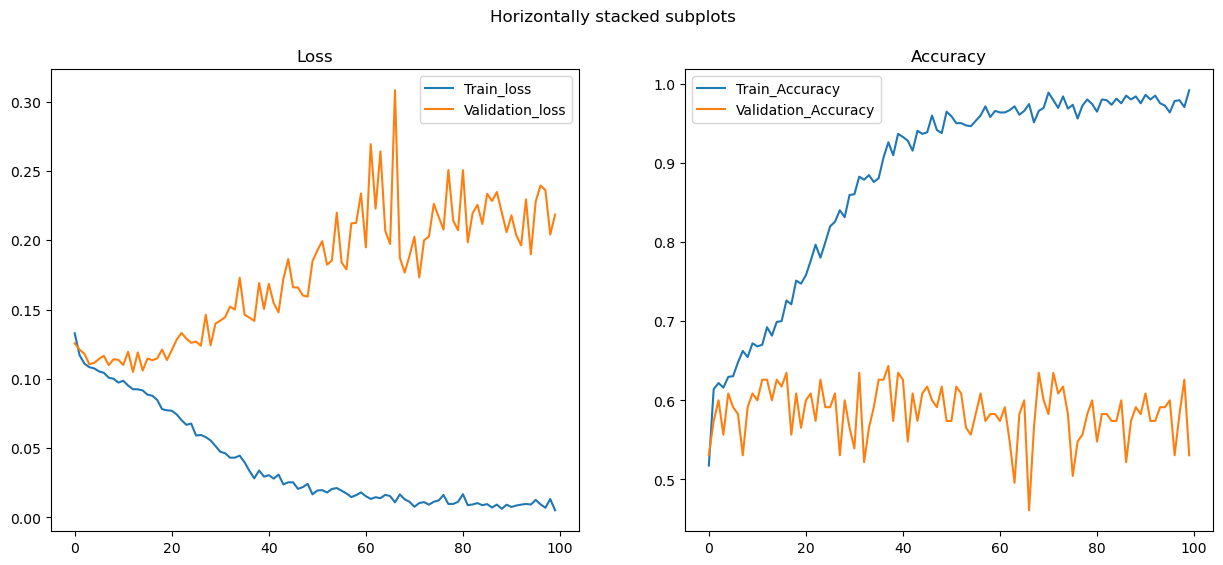

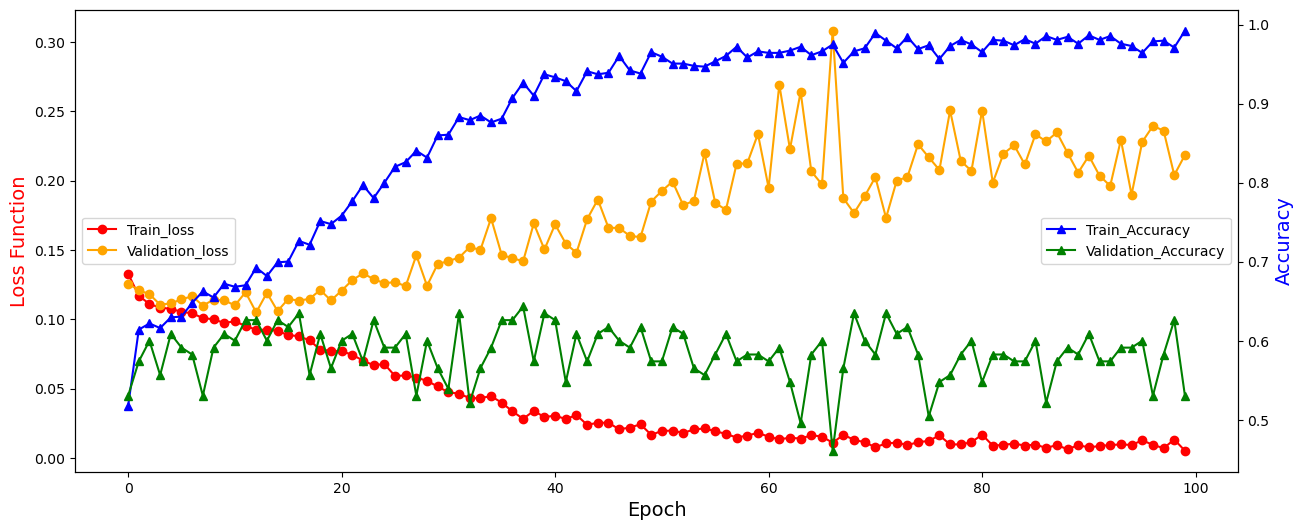

In [19]:
plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)

## Save model

In [20]:
# Save Model
NAME2 = "model_2.pt"

torch.save(modelpy, PATH+NAME2)

# Load Last Model

In [21]:
# Load the model
NAME = "model_2.pt"
modelpy = torch.load(PATH+NAME, map_location=device)
modelpy.eval()

ClassificationNet(
  (resnet50_fe): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0

## Evaluate Last Model

In [22]:
def accuracy_given_set(mm2, valid_loader, device, name="Validation"):
    # Evaluate the Validation Set
    mm2.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            new_images = data[0].to(device)

            outputs = mm2(new_images)
            predictions = torch.argmax(outputs, dim=1)

            total += data[1].size(0)
            correct +=(predictions == data[1].to(device)).sum().item()
        
    print(f'Accuracy of the network on the {total} {name} instances: {100 * correct / total}%')

In [23]:
# Calculate accuracy for Validation and Train sets
accuracy_given_set(modelpy, train_loader, device, name="Train")
accuracy_given_set(modelpy, valid_loader, device, name="Validation")

100%|██████████| 130/130 [00:37<00:00,  3.49it/s]


Accuracy of the network on the 1034 Train instances: 99.90328820116054%


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]

Accuracy of the network on the 115 Validation instances: 53.04347826086956%


## Test Predictions Last Model

In [24]:
def make_predictions(mm2, loader, device):
    # Evaluate the Validation Set
    mm2.eval()
    predictions_list = []
    name_list = []
    
    with torch.no_grad():
        for bi, data in tqdm(enumerate(loader), total=len(loader)):
            new_images = data[0].to(device)
        
            outputs = mm2(new_images)
            predictions = torch.argmax(outputs, dim=1)
        
            predictions_list.append(predictions[0].item())
            name_list.append(data[1][0])
        
    return(predictions_list, name_list)

In [25]:
pred, names = make_predictions(modelpy, test_loader, device)

np.unique(np.array(pred),return_counts=True)

100%|██████████| 380/380 [00:19<00:00, 19.99it/s]


(array([0, 1, 2, 3]), array([164, 122,  90,   4], dtype=int64))

In [26]:
save_predictions_as_csv(names, pred, name="GGC_plus_clas_v02_ResNet_prediction.csv")

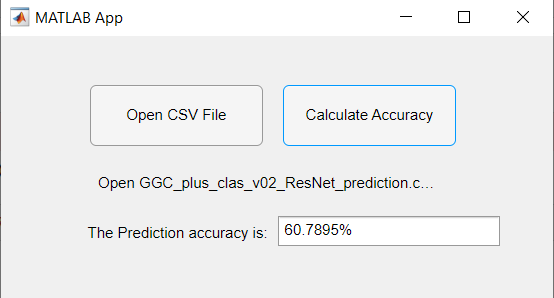

# Load Best Model

In [27]:
# Load the model
NAME = "model_2_bestModel.pt"
modelpy_bestModel = torch.load(PATH+NAME, map_location=device)
modelpy_bestModel.eval()

ClassificationNet(
  (resnet50_fe): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0

## Evaluate Best Model

In [28]:
# Calculate accuracy for Validation and Train sets
accuracy_given_set(modelpy_bestModel, train_loader, device, name="Train")
accuracy_given_set(modelpy_bestModel, valid_loader, device, name="Validation")

100%|██████████| 130/130 [00:37<00:00,  3.48it/s]


Accuracy of the network on the 1034 Train instances: 97.38878143133462%


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]

Accuracy of the network on the 115 Validation instances: 64.34782608695652%


## Test Predictions Best Model

In [29]:
pred, names = make_predictions(modelpy_bestModel, test_loader, device)

np.unique(np.array(pred),return_counts=True)

100%|██████████| 380/380 [00:17<00:00, 22.10it/s]


(array([0, 1, 2]), array([140, 179,  61], dtype=int64))

In [30]:
save_predictions_as_csv(names, pred, name="GGC_plus_clas_v02_ResNet_best_prediction.csv")

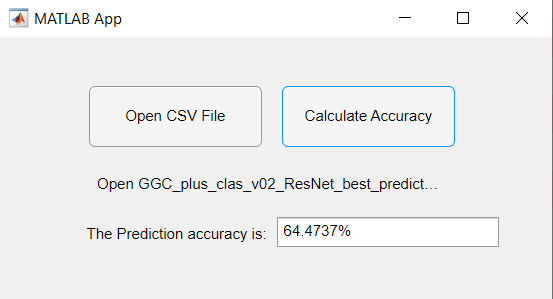